In [2]:
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader
from transformers import BlipProcessor, BlipForConditionalGeneration
import tensorflow as tf
import torch
from PIL import Image

c:\Users\jagui\miniconda3\envs\tf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
image_dir = 'C:/Jorge/Universidad/JU/2/Thesis/Datasets/Images'
dataset_file = 'C:/Jorge/Universidad/JU/2/Thesis/Datasets/Images/annotations/metadata.csv'
fine_tune_dir = 'C:/Jorge/Universidad/JU/2/Thesis/Scripts/blip-image-captioning-large/FINE_TUNE'

In [4]:
class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        encoding = self.processor(images=Image.open(image_dir + '/' + item["file_name"]), text=item["text"], padding="max_length", return_tensors="pt")
        # remove batch dimension
        encoding = {k:v.squeeze() for k,v in encoding.items()}
        return encoding

In [5]:
def load_model():
    processor = BlipProcessor.from_pretrained('.')
    model = BlipForConditionalGeneration.from_pretrained('.')
    return model, processor

In [6]:
dataset = load_dataset(path=image_dir, data_dir="annotations", split="train")
model, processor = load_model()

In [7]:
train_dataset = ImageCaptioningDataset(dataset, processor)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=4)

In [8]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([4, 3, 384, 384])
input_ids torch.Size([4, 512])
attention_mask torch.Size([4, 512])


In [9]:
processor.decode(batch["input_ids"][0])

'[CLS] one empty transparent open rectangular glass bottle with a twist finish and no closure [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 

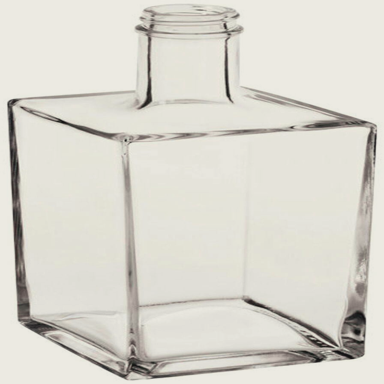

In [10]:
import numpy as np
MEAN = np.array([123.675, 116.280, 103.530]) / 255
STD = np.array([58.395, 57.120, 57.375]) / 255

unnormalized_image = (batch["pixel_values"][0].numpy() * np.array(STD)[:, None, None]) + np.array(MEAN)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
Image.fromarray(unnormalized_image)

In [11]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()

for epoch in range(3):
  print("Epoch:", epoch)
  for idx, batch in enumerate(train_dataloader):
    input_ids = batch.pop("input_ids").to(device)
    pixel_values = batch.pop("pixel_values").to(device)

    outputs = model(input_ids=input_ids,
                    pixel_values=pixel_values,
                    labels=input_ids)
    
    loss = outputs.loss
    if idx % 100 == 0:
      print("Loss:", loss.item())

    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

Epoch: 0


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Loss: 10.222519874572754
Loss: 5.989511489868164
Loss: 3.406473398208618
Loss: 1.8200297355651855
Loss: 1.487701416015625
Loss: 1.4130462408065796
Loss: 1.38753080368042
Loss: 1.3813632726669312
Loss: 1.3788589239120483
Loss: 1.366870641708374
Epoch: 1
Loss: 1.3670883178710938
Loss: 1.3638081550598145
Loss: 1.3626948595046997
Loss: 1.36106538772583
Loss: 1.3636186122894287
Loss: 1.3597663640975952
Loss: 1.361435055732727
Loss: 1.3594833612442017
Loss: 1.3605555295944214
Loss: 1.363183856010437
Epoch: 2
Loss: 1.3604158163070679
Loss: 1.359144926071167
Loss: 1.3613990545272827
Loss: 1.3603487014770508
Loss: 1.3591084480285645
Loss: 1.3593006134033203
Loss: 1.359025001525879
Loss: 1.362747311592102
Loss: 1.3592281341552734
Loss: 1.359891653060913


In [12]:
model.save_pretrained(fine_tune_dir)
processor.save_pretrained(fine_tune_dir)

[]